# Analyzing Results of Main Experiments

*Version History*

* **9.0** - Visualize distribution of weights
* **9.1** - Visualize RDMs
* **9.2** - Evaluate trained networks on FashionMNIST test set


## Preparation


### Imports & Constants

In [1]:
from collections import defaultdict
from typing import Callable, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from einops import rearrange
from matplotlib.patches import FancyArrowPatch
from pyfonts import load_font
from scipy.stats import percentileofscore
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.hooks import RemovableHandle
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

from src.datasets.fashionmnist import FashionMNIST
from src.models.lenet import LeNet
from src.rsa.rdm import compute_rdm, compare_rdm
from src.utils.classification_transforms import ClassificationTransformsVal
from src.visualization.color import get_color
from src.visualization.saving import save_figure


# Custom font & color
INDIE_FLOWER = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/indieflower/IndieFlower-Regular.ttf?raw=true"
)
ANTHRACITE = get_color("anthracite", tint=0.2)

# Paths
CHECKPOINT_DIR = "../out/lenet_fashionmnist/representational_similarity/methods/2024-10-20_11-09-04"
CHECKPOINT_DIR_SPEARMAN = "../out/lenet_fashionmnist/representational_similarity/methods/2025-01-15_09-48-05"
LENET_REF_CHECKPOINT = "../models/lenet_fashionmnist_basic/checkpoint.pt"

# CPU/GPU
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Reference LeNet-5
LENET_REF = LeNet().to(DEVICE)
LENET_REF.load_state_dict(
    torch.load(
        LENET_REF_CHECKPOINT,
        map_location=DEVICE,
        weights_only=False
    )["model_state_dict"]
)
LENET_REF.eval()

# Layer names
LAYER_ALIASES_WEIGHTS = {
    "net.0": "Conv-1",
    "net.3": "Conv-2",
    "net.6": "FC-1",
    "net.9": "FC-2",
    "net.11": "FC-3"
}
LAYER_NAMES_RDMS = [
    "net.2",  # ReLU after 1st convolutional layer
    "net.5",  # ReLU after 2nd convolutional layer
    "net.7",  # ReLU after 1st fully connected layer
    "net.10"  # ReLU after 2nd fully connected layer (penultimate layer)
]

# Methods for computing & comparing RDMs
COMPUTE_STR_DICT = {
    "correlation/None": "Correlation Distance",
    "euclidean/False": "Squared Euclidean Dist.",
    "euclidean/True": "Squared Euclidean Dist. (Centered)",
    "cosine/None": "Cosine Distance"
}
COMPARE_STR_DICT = {
    "reference": "Reference LeNet-5",
    "spearman": r"Spearman's $\rho_S$",
    "correlation": r"Pearson's $\rho$",
    "cosine": "Cosine Similarity"
}

# FashionMNIST (test split)
FASHIONMNIST_TEST = FashionMNIST(
    data_dir="../data",
    train=False,
    load_into_memory=False,
    transform=ClassificationTransformsVal(
        mean=[0.2860],
        std=[0.3205],
        resize_size=32,
        crop_size=32
    )
)

## Distribution of Weights

**1. Choose which methods to visualize weights for**

In [2]:
compute_list = ["correlation/None", "euclidean/False", "euclidean/False"]
compare_list = ["spearman", "spearman", "cosine"]
run_list = [1, 1, 1]

**2. Extract weights of LeNet-5s trained for dissimilarity**

In [3]:
# List to store all weights data.  This will later be converted into a DataFrame for plotting with seaborn.
weights_data: List[Tuple[str, str, str, float]] = []

for compute, compare, run in zip(compute_list, compare_list, run_list):
    # Load checkpoint
    cmp, cntr = compute.split("/")
    checkpoint_path = (
        f"{CHECKPOINT_DIR if compare != 'spearman' else CHECKPOINT_DIR_SPEARMAN}/"
        f"compute={cmp},compare={compare},compute.cntr_actv={cntr}/checkpoints/run{run}/best_performing.pt"
    )
    model_state_dict = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)["model_state_dict"]

    # Store weights in ``weights_data`` list
    for layer_name, weight_tensor in model_state_dict.items():
        if "weight" in layer_name:
            weights_flattened = weight_tensor.cpu().numpy().flatten()
            for weight in weights_flattened:
                weights_data.append((
                    "trained",                                                       # which network (hue)
                    f"{COMPUTE_STR_DICT[compute]} \n& {COMPARE_STR_DICT[compare]}",  # RSA methods (columns)
                    LAYER_ALIASES_WEIGHTS[layer_name.replace(".weight", "")],        # layer name (rows)
                    weight                                                           # value to be plotted via KDE
                ))

**3. Load weights of reference LeNet-5**

In [4]:
# Load checkpoint of reference LeNet-5
ref_state_dict = torch.load(
    LENET_REF_CHECKPOINT, map_location=DEVICE, weights_only=False
)["model_state_dict"]

# Store weights in ``weights_data`` list
for layer_name, weight_tensor in ref_state_dict.items():
    if "weight" in layer_name:
        weights_flattened = weight_tensor.cpu().numpy().flatten()
        for compute, compare in zip(compute_list, compare_list):
            for weight in weights_flattened:
                weights_data.append((
                    "reference",                                                     # which network (hue)
                    f"{COMPUTE_STR_DICT[compute]} \n& {COMPARE_STR_DICT[compare]}",  # RSA methods (columns)
                    LAYER_ALIASES_WEIGHTS[layer_name.replace(".weight", "")],        # layer name (rows)
                    weight                                                           # value to be plotted via KDE
                ))

**4. Convert data to DataFrame**

In [5]:
weights_df = pd.DataFrame(weights_data, columns=["network", "method", "layer", "weight"])
weights_df.head(10)

,network,method,layer,weight
0,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,0.195744
1,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.049322
2,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.056948
3,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,0.167970
4,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.190352
5,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,0.234016
6,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.105093
7,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.098893
8,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,0.194787
9,trained,Correlation Distance \n& Spearman's $\rho_S$,Conv-1,-0.161698


**5. Visualize distributions**

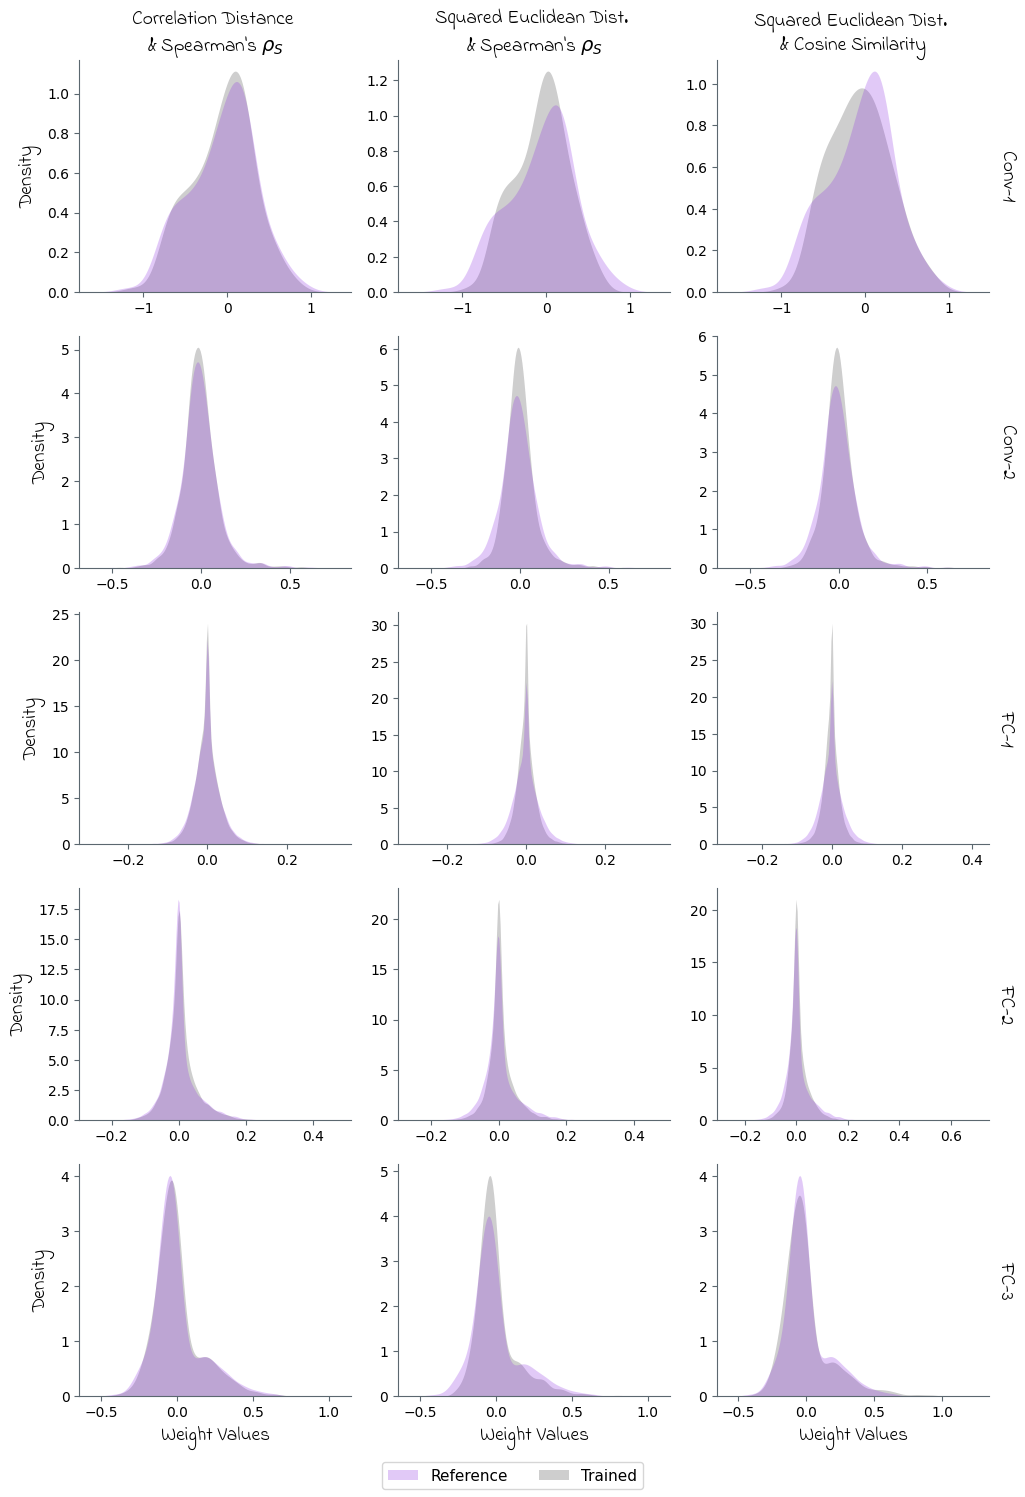

In [6]:
font_size = 14

colors = sns.color_palette("bright")
dark = sns.color_palette("dark")
palette = [dark[-3], colors[4]]

with sns.axes_style({"axes.edgecolor": ANTHRACITE}):
    g = sns.FacetGrid(
        data=weights_df,
        row="layer",
        col="method",
        hue="network",
        sharex=False,
        sharey=False,
        aspect=1.15,
        palette=palette,
        margin_titles=True
    )
    _ = g.map(sns.kdeplot, "weight", fill=True, linewidth=0)

# Modify ticks, axis labels, & margin titles
g.tick_params(color=ANTHRACITE, labelsize=font_size - 4)
g.set_axis_labels("Weight Values", "Density", font=INDIE_FLOWER, size=font_size)
g.set_titles(
    row_template="{row_name}",
    col_template="{col_name}",
    font=INDIE_FLOWER,
    size=font_size
)

# Add legend
g.fig.legend(
    handles=list(reversed(g._legend_data.values())),
    labels=list(reversed([k.title() for k in g._legend_data])),
    loc="lower center",
    ncol=len(compute_list),
    fontsize=font_size - 3
)

plt.tight_layout(rect=(0, 0.02, 1, 1))  # adjusted for legend
plt.show()

In [7]:
# Save figure
fig_weights_dist = g.figure
save_figure(
    fig_weights_dist,
    "../reports/figures/lenet_fashionmnist/representational_similarity/analysis/weights_distribution.png"
)

Figure saved successfully as ../reports/figures/lenet_fashionmnist/representational_similarity/analysis/weights_distribution.png.


## RDMs

**1. Define helper functions**

In [8]:
def load_model(
    compute: str,
    compare: str,
    center: str,
    run: int = 1
) -> LeNet:
    """Return LeNet-5 with weights loaded from specified checkpoint."""

    checkpoint_path = (
        f"{CHECKPOINT_DIR if compare != 'spearman' else CHECKPOINT_DIR_SPEARMAN}/"
        f"compute={compute},compare={compare},compute.cntr_actv={center}/checkpoints/run{run}/best_performing.pt"
    )
    model_state_dict = torch.load(
        checkpoint_path,
        map_location=DEVICE,
        weights_only=False
    )["model_state_dict"]

    model = LeNet().to(DEVICE)
    model.load_state_dict(model_state_dict)
    model.eval()

    return model


def sample_by_class(
    n_samples_per_class: int,
    seed: int = 37
) -> Tuple[Dict[int, List[int]], List[int], List[int]]:
    """Randomly sample images from each class in the dataset.
    
    Args:
        n_samples_per_class: Number of samples to select per class.
        seed: Random seed for reproducibility.
    
    Returns:
        Tuple containing:
        - Dictionary mapping class indices to lists of dataset indices
        - Flat list of all selected indices
        - List of corresponding class labels for the selected indices
    """
    
    # Initialize random number generator
    rng = np.random.default_rng(seed)
    
    # Group indices by class
    indices_by_class = defaultdict(list)
    for idx, target in enumerate(FASHIONMNIST_TEST.targets):
        indices_by_class[target].append(idx)
    
    # Sample from each class
    sampled_indices_by_class = {}
    all_sampled_indices = []
    all_sampled_labels = []
    for class_idx, indices in indices_by_class.items():
        indices_array = np.array(indices)
        sampled = rng.choice(indices_array, size=n_samples_per_class, replace=False).tolist()
        sampled_indices_by_class[class_idx] = sampled
        all_sampled_indices.extend(sampled)
        all_sampled_labels.extend([class_idx] * n_samples_per_class)
    
    return sampled_indices_by_class, all_sampled_indices, all_sampled_labels


class ActivationHook:
    """Helper class to collect intermediate activations."""
    
    def __init__(self):
        self.activation = None
    
    def __call__(self, module, input, output):
        self.activation = output.detach().cpu()
    
    def register_activation_hook(
        self,
        model,
        layer_name,
        activation_list
    ):
        """Register a hook for a specific layer of the model."""

        # Define hook function to attach
        def hook(module, input, output):
            activation_list.append(output.detach().cpu())
        
        for name, module in model.named_modules():
            if name == layer_name:
                return module.register_forward_hook(hook)
        raise ValueError(f"Layer {layer_name} not found in model.")


def collect_activations(
    model: torch.nn.Module,
    indices: List[int],
    activation_hooks: Dict[str, Callable]
) -> Dict[str, torch.Tensor]:
    """Collect activations from specific layers for given samples.
    
    Args:
        model: Model to collect activations for.
        indices: List of dataset indices to use as inputs ot the model.
        activation_hooks: Dictionary mapping layer names to hook
          functions.
    
    Returns:
        Dictionary mapping layer names to activation tensors.
    """
    
    model.eval()
    subset = Subset(FASHIONMNIST_TEST, indices)
    activations = defaultdict(list)
    
    # Register hooks
    handles = []
    for layer_name, hook_fn in activation_hooks.items():
        handles.append(hook_fn.register_activation_hook(model, layer_name, activations[layer_name]))
    
    # Process samples to collect activations
    with torch.no_grad():
        for img, _ in tqdm(subset, desc="Collecting activations", leave=False):
            img = img.unsqueeze(0).to(DEVICE)
            model(img)
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    # Convert list of activation tensors of shape (1, C, H, W) to single tensor of shape (n_samples_per_class, C, H, W)
    activations = {
        layer_name: torch.cat(acts, dim=0)
        for layer_name, acts in activations.items()
    }

    # Flatten activation tensor from shape (n_samples_per_class, C, H, W) to shape (n_samples_per_class, C * H * W)
    activations = {
        layer_name: acts.view(acts.shape[0], -1) if acts.dim() > 2 else acts
        for layer_name, acts in activations.items()
    }

    return activations


def reconstruct_symmetric_matrix(
    flat_vector: np.ndarray,
    n: int
) -> np.ndarray:

    matrix = np.zeros((n, n), dtype=flat_vector.dtype)
    idx = 0
    for i in range(n):
        for j in range(i + 1, n):
            matrix[i, j] = flat_vector[idx]
            idx += 1
    matrix = matrix + matrix.T
    
    return matrix


**2. Set parameters for analysis**

In [9]:
# NOTE: This determines which models will be compared
compute_list = ["correlation/None", "euclidean/False", "cosine/None"]  # columns of figure at the end of this section
compare_list = ["reference", "spearman", "correlation", "cosine"]      # rows of figure at the end of this section

# Number of images to use from each class of the FashionMNIST test split
n_samples_per_class = 20

# Choose whether to plot the entire RDM, or just the lower triangular part
LOWER_TRIANGULAR_ONLY = False

**3. Load networks**

In [10]:
models = {}
for compute in compute_list:
    for compare in compare_list:
        if compare == "reference":
            models[(compute, compare)] = LENET_REF
        else:
            cmp, cntr = compute.split("/")
            models[(compute, compare)] = load_model(cmp, compare, cntr)

**4. Collect activations**

In [11]:
# Sample images
indices_by_class, all_indices, labels = sample_by_class(n_samples_per_class)

# Collect activations for each model from penultimate layer ("net.10")
# NOTE: These will be the same for all instances where ``compare=="reference"``
activations_dict = {}
for (compute, compare), model in models.items():
    activations_dict[(compute, compare)] = collect_activations(
        model=model,
        indices=all_indices,
        activation_hooks={"net.10": ActivationHook()}
    )["net.10"]

**5. Compute RDMs & similarity scores**

In [12]:
# Compute RDMs
rdms_dict = {}
for (compute, compare), activations in activations_dict.items():
    cmp, cntr = compute.split("/")
    if cmp == "euclidean":
        rdms_dict[(compute, compare)] = compute_rdm(
            activations=activations,
            method=cmp,
            center_activations=(cntr=="True")
        )
    else:
        rdms_dict[(compute, compare)] = compute_rdm(
            activations=activations,
            method=cmp
        )

# Compute similarity scores
scores_dict = {}
for (compute, compare), rdm_flat in rdms_dict.items():
    if compare != "reference":
        reference_rdm_flat = rdms_dict[(compute, "reference")]

        compute_str = COMPUTE_STR_DICT[compute]
        compare_str = COMPARE_STR_DICT[compare]

        scores_dict[(compute_str, compare_str)] = compare_rdm(
            rdm_flat,
            reference_rdm_flat,
            method=compare
        )

**6. Convert dictionary to long-form DataFrame**

In [13]:
n_stimuli = n_samples_per_class * len(FASHIONMNIST_TEST.classes)
data = []

for (compute, compare), rdm_flat in rdms_dict.items():
    # Convert RDM entries to percentiles and recover square matrix from flattened version
    percentile_rdm_flat = percentileofscore(rdm_flat, rdm_flat, kind="rank")
    percentile_rdm = reconstruct_symmetric_matrix(
        flat_vector=percentile_rdm_flat,
        n=n_stimuli
    )

    # Prepare method descriptions for plotting
    compute_str = COMPUTE_STR_DICT[compute]
    compare_str = COMPARE_STR_DICT[compare]

    # Unpack matrix entries
    mask = np.ones_like(percentile_rdm, dtype=bool)
    if LOWER_TRIANGULAR_ONLY:
        mask = ~np.triu(mask)
    
    for i in range(percentile_rdm.shape[0]):
        for j in range(percentile_rdm.shape[1]):
            if mask[i, j]:
                data.append([compute_str, compare_str, i, j, percentile_rdm[i, j]])

# Create DataFrame
percentile_rdms_df = pd.DataFrame(
    data,
    columns=["compute", "compare", "row", "col", "value"]
)

**6. Plot RDMs**

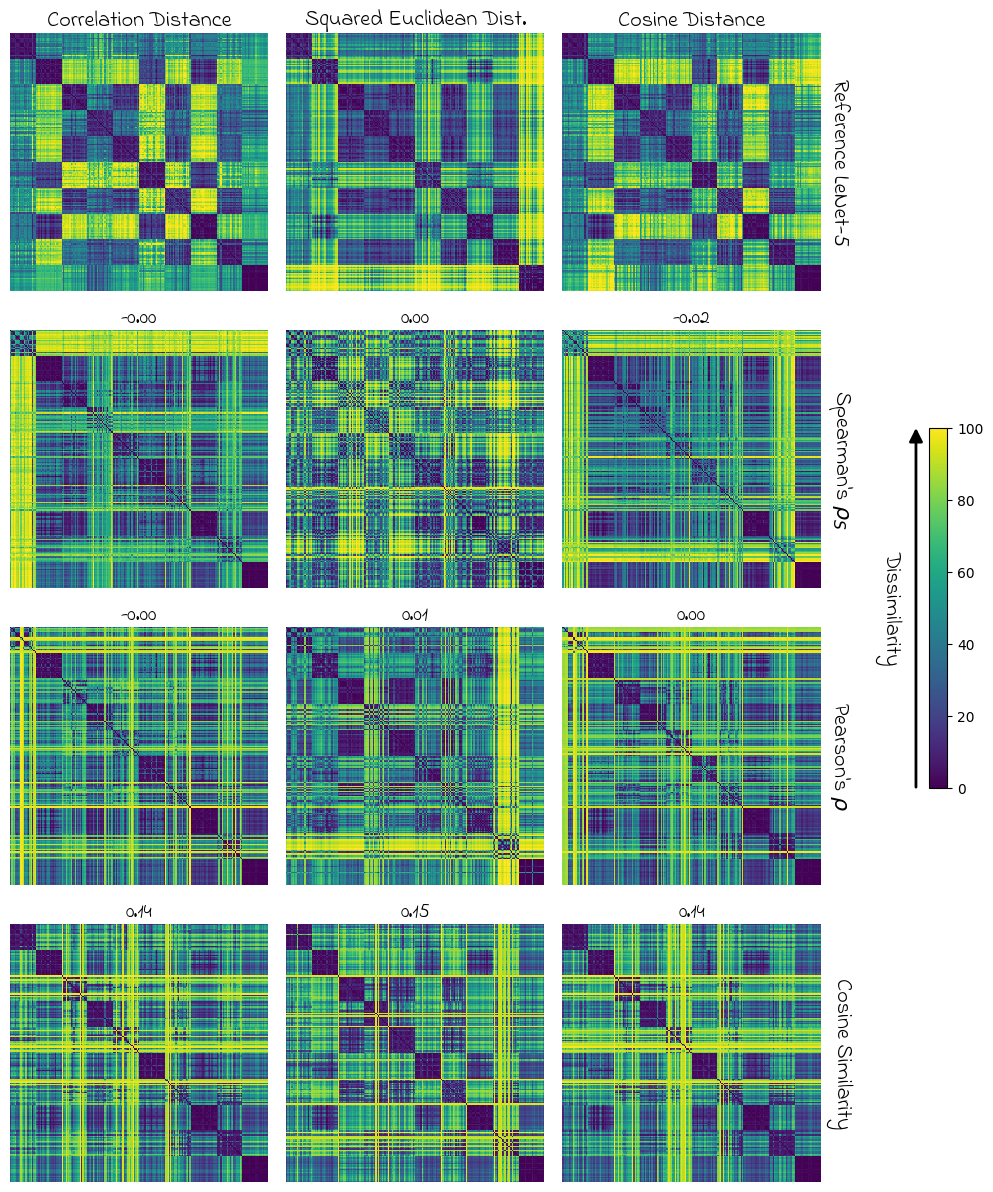

In [14]:
font_size = 16

def heatmap(data, ax, row_name=None, col_name=None, **kwargs):
    data = data.pivot(index="row", columns="col", values="value")
    sns.heatmap(data, ax=ax, **kwargs)
    
    if row_name != "Reference LeNet-5":
        score = scores_dict[(col_name, row_name)]
        ax.text(
            0.5, 1.03,
            f"{score:.2f}",
            ha="center",
            transform=ax.transAxes,
            font=INDIE_FLOWER,
            fontsize=font_size - 2
        )


def map_with_scores(data, **kwargs):
    ax = plt.gca()
    # Get the current row and column names from the data
    row_name = data["compare"].iloc[0]
    col_name = data["compute"].iloc[0]
    return heatmap(data, ax=ax, row_name=row_name, col_name=col_name, **kwargs)


# Plot data
g = sns.FacetGrid(
    percentile_rdms_df,
    row="compare",
    col="compute",
    margin_titles=True
)
mappable = g.map_dataframe(
    map_with_scores,
    vmin=0,
    vmax=100,
    xticklabels=False,
    yticklabels=False,
    square=True,
    cbar=False,
    cmap="viridis"
)

# Remove axis labels & modify margin titles
g.set_axis_labels("", "")
g.set_titles(
    row_template="{row_name}",
    col_template="{col_name}",
    font=INDIE_FLOWER,
    size=font_size
)
g.figure.subplots_adjust(wspace=0, hspace=0.15)

# Add colorbar & annotation 
fig = plt.gcf()
cbar_ax = fig.add_axes([1.07, 0.35, 0.02, 0.3])
plt.colorbar(
    mappable.axes[0, 0].collections[0],
    cax=cbar_ax,
    
)
arrow_ax = fig.add_axes([1.045, 0.348, 0.02, 0.304])
arrow_ax.add_patch(
    FancyArrowPatch(
        (0.5, 0), (0.5, 1),
        transform=arrow_ax.transAxes,
        color="black",
        arrowstyle="-|>",
        mutation_scale=20,
        linewidth=2
    ))
arrow_ax.text(
    -1.0, 0.5,
    "Dissimilarity",
    rotation=270,
    va="center",
    ha="center",
    font=INDIE_FLOWER,
    fontsize=font_size
)
arrow_ax.axis("off")

plt.show()

In [15]:
# Save figure
fig_rdms = g.figure
save_figure(
    fig_rdms,
    "../reports/figures/lenet_fashionmnist/representational_similarity/analysis/rdms.png"
)

Figure saved successfully as ../reports/figures/lenet_fashionmnist/representational_similarity/analysis/rdms.png.


## Distribution of Pairwise Dissimilarities

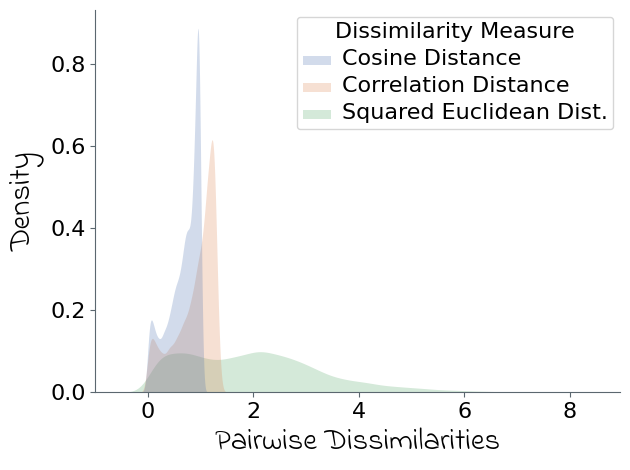

In [16]:
map_cmp = {
    "correlation": r"Pearson's $\rho$",
    "cosine": "Cosine Similarity",
    "euclidean": "Euclidean Dist."
}

# Collect RDMs of reference LeNet-5
data = []
for (compute, compare), rdm_flat in rdms_dict.items():
    if compare == "reference":
        for x in rdm_flat:
            data.append([COMPUTE_STR_DICT[compute], x.item()])

# Convert to DataFrame
df = pd.DataFrame(
    data,
    columns=["Dissimilarity Measure", "x"]
)

# Plot data
with sns.axes_style({"axes.edgecolor": ANTHRACITE}):
    ax = sns.kdeplot(
        data=df,
        x="x",
        hue="Dissimilarity Measure",
        fill=True,
        linewidth=0,
        palette="deep",
        hue_order=[
            "Cosine Distance",
            r"Correlation Distance",
            "Squared Euclidean Dist."
        ]
    )

# Modify axes and axes labels
sns.despine(ax=ax)
ax.tick_params(color=ANTHRACITE, labelsize=font_size)
ax.set_xlabel("Pairwise Dissimilarities", font=INDIE_FLOWER, size=font_size + 6)
ax.set_ylabel("Density", font=INDIE_FLOWER, size=font_size + 6)

# Increase font size of legend title & entries
legend = ax.get_legend()
plt.setp(legend.get_texts(), fontsize=font_size)
plt.setp(legend.get_title(), fontsize=font_size)

plt.tight_layout()
plt.show()

In [17]:
# Save figure
fig_rdm_dists = ax.get_figure()
save_figure(
    fig_rdm_dists,
    "../reports/figures/lenet_fashionmnist/representational_similarity/analysis/rdm_distributions.png"
)

Figure saved successfully as ../reports/figures/lenet_fashionmnist/representational_similarity/analysis/rdm_distributions.png.


## Evaluating Networks on FashionMNIST Test Set

**1. Define helper function to evaluate networks**

In [18]:
def register_hook(
    model: nn.Module,
    layer: str,
    activations: Dict[str, torch.Tensor],
    activations_key: str
) -> RemovableHandle:

    def hook(module, args, output) -> None:
        activations[activations_key] = output

    module = model
    for name in layer.split("."):
        if name.isdigit():
            module = module[int(name)]
        else:
            module = getattr(module, name)

    return module.register_forward_hook(hook)


def reshape_activations(activations: torch.Tensor) -> torch.Tensor:

    if activations.dim() == 4:  # conv. layers
        return rearrange(activations, "b c h w -> b (c h w)")
    return activations


def evaluate_on_test_set(
    model: nn.Module,
    compute: str,
    compare: str,
    run: int
) -> Dict[str, float]:

    cmp, cntr = compute.split("/")
    cntr_bool = cntr == "True"

    model.eval()
    model.to(DEVICE)
    LENET_REF.to(DEVICE)

    # Attach hooks
    activations = {}
    hooks = {
        "trained": register_hook(
            model=model,
            activations=activations,
            layer="net.10",
            activations_key="trained"
        ),
        "reference": register_hook(
            model=LENET_REF,
            activations=activations,
            layer="net.10",
            activations_key="reference"
        )
    }

    criterion = nn.CrossEntropyLoss()
    accuracy = MulticlassAccuracy(
        num_classes=len(FASHIONMNIST_TEST.classes),  # 10
        top_k=1,
        average="micro",
        multidim_average="global"
    ).to(DEVICE)

    # NOTE: We set shuffle=True to ensure that all batches contain images from all 10 classes, which is important for
    #       computing and comparing RDMs!
    torch.manual_seed(0)
    dataloader = DataLoader(
        FASHIONMNIST_TEST,
        batch_size=64,  # same as during training
        shuffle=True,
        num_workers=0
    )

    running_loss = 0.
    running_rsa = 0.

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Evaluating network ({compute}, {compare}, run{run})", leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            predictions_trained = model(inputs)
            predictions_reference = LENET_REF(inputs)

            # Compute and track loss
            samples = targets.size(dim=0)
            loss = criterion(predictions_trained, targets)
            running_loss += loss.item() * samples

            # Compute and track accuracy
            accuracy.update(predictions_trained, targets)

            # Compute and track RSA score
            activations_trained = reshape_activations(activations["trained"])
            activations_reference = reshape_activations(activations["reference"])
            
            if cmp == "euclidean":
                rdm_trained = compute_rdm(activations_trained, method="euclidean", center_activations=cntr_bool)
                rdm_reference = compute_rdm(activations_reference, method="euclidean", center_activations=cntr_bool)
            else:
                rdm_trained = compute_rdm(activations_trained, method=cmp)
                rdm_reference = compute_rdm(activations_reference, method=cmp)
                
            running_rsa += compare_rdm(rdm_trained, rdm_reference, method=compare).item() * samples

    # Detach hooks
    for handle in hooks.values():
        handle.remove()
            
    # Compute final results
    results = {
        "accuracy": accuracy.compute().item(),
        "loss": running_loss / len(FASHIONMNIST_TEST),
        "rsa": running_rsa / len(FASHIONMNIST_TEST)
    }
    return results


**2. Choose which networks to evaluate**

In [19]:
compute_list = ["cosine/None", "correlation/None", "euclidean/False", "euclidean/True"]  # all methods
compare_list = ["spearman", "correlation", "cosine"]  # all methods
runs_list = [1, 2, 3, 4, 5]  # all five cross-validation runs

**3. Load and evaluate networks**

In [20]:
results_dict = {}
for compute in compute_list:
    for compare in compare_list:
        for run in runs_list:
            cmp, cntr = compute.split("/")
            results_dict[(compute, compare, run)] = evaluate_on_test_set(
                model=load_model(cmp, compare, cntr, run),
                compute=compute,
                compare=compare,
                run=run
            )

**4. Convert data to DataFrame**

In [21]:
data = []
for (compute, compare, run), results in results_dict.items():
    data.append([
        compute, compare, run, round(results["accuracy"], 3), round(results["loss"], 3), round(results["rsa"], 2)
    ])

results_df = pd.DataFrame(
    data,
    columns=["compute", "compare", "run", "accuracy", "loss", "rsa"]
)

**5. Compute statistics with seaborn**

In [22]:
# NOTE: Quick hack!
def get_statistics(parameter: str) -> pd.DataFrame:
    
    # Create plot to let seaborn compute statistics across cross-validation runs
    ax = sns.pointplot(
        data=results_df,
        x=parameter,
        y="compute",
        hue="compare",
        errorbar=("ci", 95),
        seed=42
    )

    # Extract data from plot
    lines = ax.get_lines()
    data = []
    i = 0
    for compare in compare_list:
        compute_means = lines[i].get_xdata()  # means for fixed ``compare`` method and all ``compute`` methods
        for j, compute in enumerate(compute_list):
            i += 1
            ci = lines[i].get_xdata()
            data.append([compute, compare, compute_means[j], ci[0], ci[1]])
        i += 1

    plt.close()

    df = pd.DataFrame(
        data,
        columns=["compute", "compare", f"mean_{parameter}", f"ci_lower_{parameter}", f"ci_upper_{parameter}"]
    )
    return df


# Compute statistics
accuracy_df = get_statistics("accuracy")
rsa_df = get_statistics("rsa")
combined_df = pd.merge(
    accuracy_df,
    rsa_df,
    on=["compute", "compare"],
    how="inner"
)
combined_df = combined_df.round({
    "mean_accuracy": 3,
    "ci_lower_accuracy": 4,
    "ci_upper_accuracy": 4,
    "mean_rsa": 2,
    "ci_lower_rsa": 3,
    "ci_upper_rsa": 3
})
combined_df

,compute,compare,mean_accuracy,ci_lower_accuracy,ci_upper_accuracy,mean_rsa,ci_lower_rsa,ci_upper_rsa
0,cosine/None,spearman,0.907,0.9050,0.9084,0.01,-0.004,0.016
1,correlation/None,spearman,0.909,0.9076,0.9094,0.01,0.004,0.010
2,euclidean/False,spearman,0.906,0.9042,0.9074,0.01,-0.004,0.014
3,euclidean/True,spearman,0.907,0.9054,0.9084,0.01,0.002,0.014
4,cosine/None,correlation,0.911,0.9104,0.9116,0.01,0.010,0.010
5,correlation/None,correlation,0.913,0.9118,0.9134,0.01,0.010,0.010
6,euclidean/False,correlation,0.910,0.9096,0.9114,-0.01,-0.010,0.002
7,euclidean/True,correlation,0.910,0.9094,0.9108,-0.01,-0.010,-0.010
8,cosine/None,cosine,0.910,0.9096,0.9108,0.23,0.224,0.236
9,correlation/None,cosine,0.907,0.8992,0.9108,0.24,0.230,0.268
